# Colour visualisation

In [34]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# custom
from reflectance import spectrum_utils, file_ops, optimisation_pipeline, plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'wvs' is not defined

In [51]:
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)
AOP_model = spectrum_utils.load_aop_model(aop_group_num=1)
AOP_args = (
    AOP_model.bb_m.values,
    AOP_model.bb_c.values,
    AOP_model.Kd_m.values,
    AOP_model.Kd_c.values,
)
wvs = AOP_model.index

endmember_class_schema = "three_endmember"
endmember_array = optimisation_pipeline.GenerateEndmembers(
    endmember_class_map = glob_cfg.endmember_schema[endmember_class_schema],
    endmember_dimensionality_reduction = "mean"
    ).generate_endmembers()

endmember_cats = endmember_array.index

In [49]:
algae_sim_spectra, metadata = spectrum_utils.simulate_spectra(endmember_array, wvs, AOP_args, (1, 0, 0), N=1)  # Rb values: algae, coral, sand
coral_sim_spectra, metadata = spectrum_utils.simulate_spectra(endmember_array, wvs, AOP_args, (0, 1, 0), N=1)  # Rb values: algae, coral, sand
sand_sim_spectra, metadata = spectrum_utils.simulate_spectra(endmember_array, wvs, AOP_args, (0, 0, 1), N=1)  # Rb values: algae, coral, sand

all_spectra = np.concatenate([algae_sim_spectra, coral_sim_spectra, sand_sim_spectra], axis=0)
flattened_sim_spectra = all_spectra.reshape(-1, all_spectra.shape[-1])

Generating simulated spectra:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/10000 [00:00<?, ?it/s]

In [64]:
spectra_df = pd.DataFrame(flattened_sim_spectra, columns = wvs)
norm_rgb_values = plotting.generate_spectra_color(spectra_df)

In [62]:
norm_rgb_values.shape

(30000, 3)

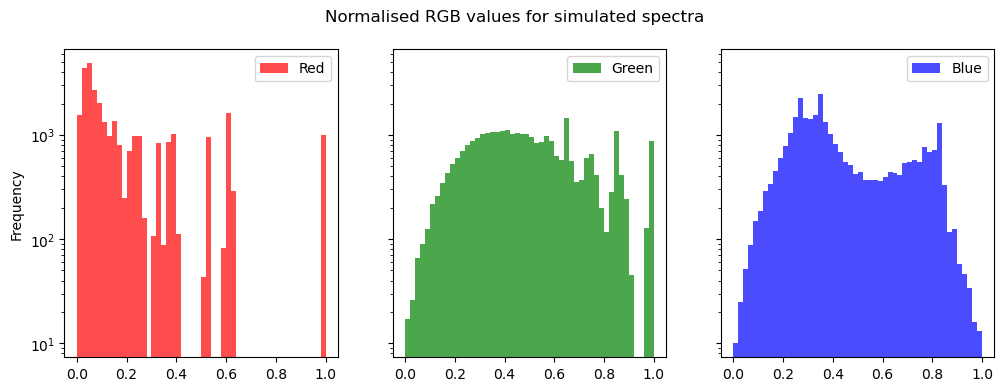

In [63]:
# plot histogram of red, green, and blue values
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

norm_reds = norm_rgb_values[:, 0]
norm_greens = norm_rgb_values[:, 1]
norm_blues = norm_rgb_values[:, 2]

plt.suptitle("Normalised RGB values for simulated spectra")
for i, (ax, rgb, colour) in enumerate(zip(axs, [norm_reds, norm_greens, norm_blues], ["Red", "Green", "Blue"])):
    ax.hist(rgb, bins=50, color=colour, alpha=0.7, label=colour)
    ax.set_yscale('log')
    ax.legend()
axs[0].set_ylabel("Frequency");

Plotting algae spectra:   0%|          | 0/1000 [00:00<?, ?it/s]

Plotting coral spectra:   0%|          | 0/1000 [00:00<?, ?it/s]

Plotting sand spectra:   0%|          | 0/1000 [00:00<?, ?it/s]

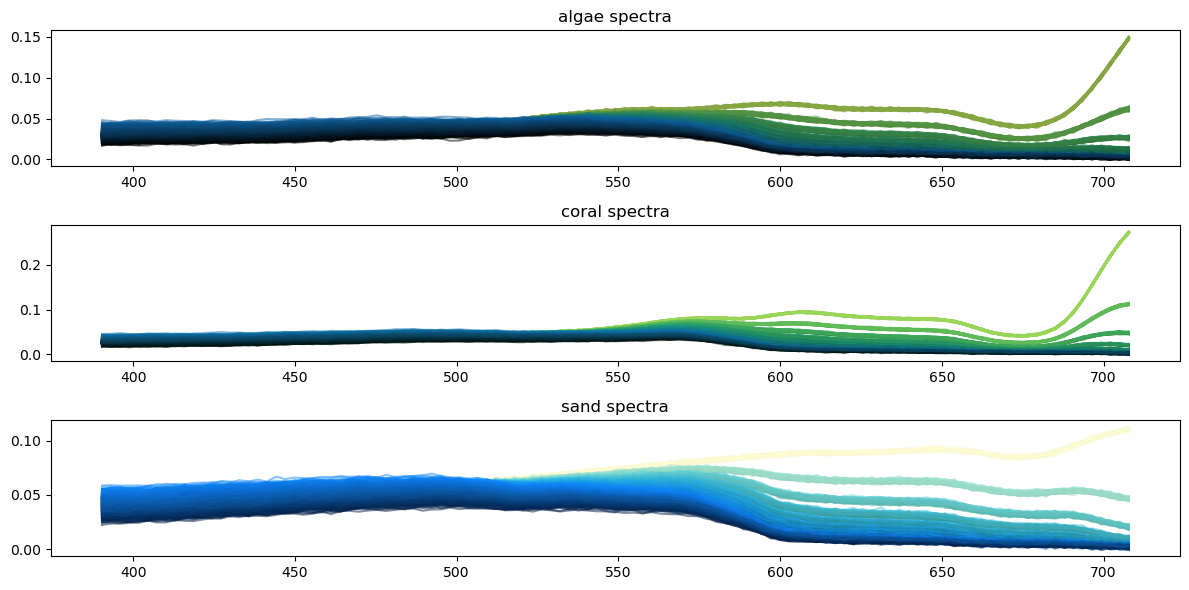

In [65]:
# plot spectra in RGB space
subset_interval = 10

from tqdm.auto import tqdm

fig, axes = plt.subplots(nrows=3, figsize=(12, 6))

for s, (spectra, spectra_title) in enumerate(zip([algae_sim_spectra, coral_sim_spectra, sand_sim_spectra], ["algae", "coral", "sand"])):
    # flatten spectrum
    flat_spectra = spectra.reshape(-1, 113)
    # select subset
    lim_spectra = flat_spectra[::subset_interval]
    
    for i, spectrum in tqdm(enumerate(lim_spectra), total=len(lim_spectra), desc=f"Plotting {spectra_title} spectra"):
        axes[s].plot(wvs, spectrum, color=norm_rgb_values[len(flat_spectra)*s:(s+1)*len(flat_spectra)][::subset_interval][i], alpha=0.5)
        
    axes[s].set_title(f"{list(endmember_cats)[s]} spectra")
        
plt.tight_layout()

# AOP model visualisations

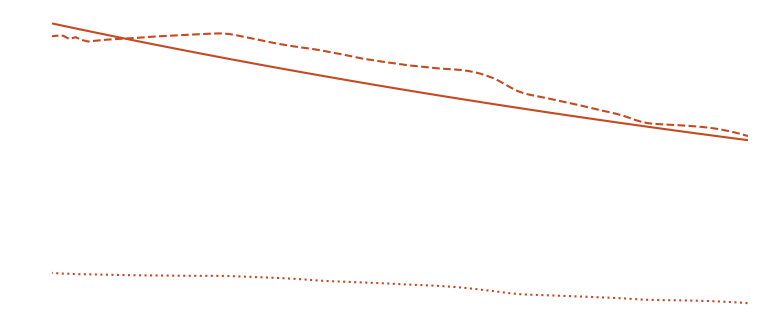

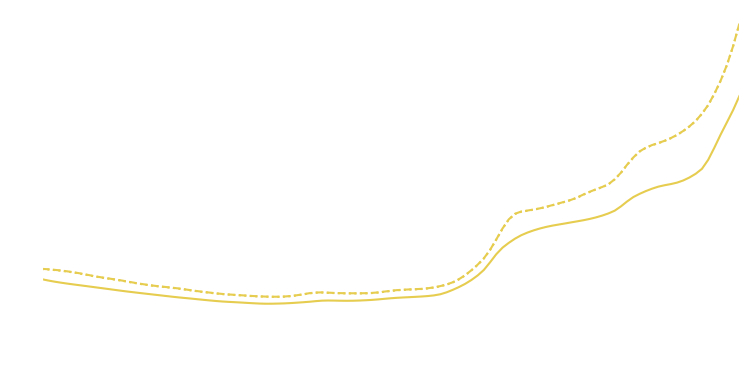

In [8]:
AOP_model = spectrum_utils.load_aop_model(aop_group_num=1)
red_hex = "#C64922"
yellow_hex = "#E6CC4F"
styles = ['-', '-', '--', ':']
    
# compare AOP models    
bb_f, bb_axes = plt.subplots(1, 1, figsize=(9, 4))
K_f, K_axes = plt.subplots(1, 1, figsize=(9, 4))

for aop_group_num in range(1, 4):
    AOP_model = spectrum_utils.load_aop_model(aop_group_num=aop_group_num)
    wvs = AOP_model.index

    K_axes.plot(wvs, AOP_model.loc[wvs].Kd_m + AOP_model.loc[wvs].Kd_c, ls=styles[aop_group_num], color=yellow_hex, label=f"Group {aop_group_num}", alpha=1)
    bb_axes.plot(wvs, AOP_model.loc[wvs].bb_m + AOP_model.loc[wvs].bb_c, ls=styles[aop_group_num], color=red_hex, label=f"Group {aop_group_num}", alpha=1)

for ax in (bb_axes, K_axes):
    # ax.patch.set_alpha(0)
    ax.set_xlim(min(wvs), max(wvs))
    # set outside ticks and lines to be white
    [ax.spines[pos].set_color('white') for pos in ax.spines.keys()]
    # set ticks to be white
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
    
# remove numbers from bb_axes x axis
bb_axes.set_xticklabels([])
K_axes.set_xlabel("Wavelength (nm)", color="white")

# save figs
bb_f.savefig(file_ops.RESULTS_DIR_FP / "figures/bb_models.png", dpi=300, transparent=True)
K_f.savefig(file_ops.RESULTS_DIR_FP / "figures/K_models.png", dpi=300, transparent=True)


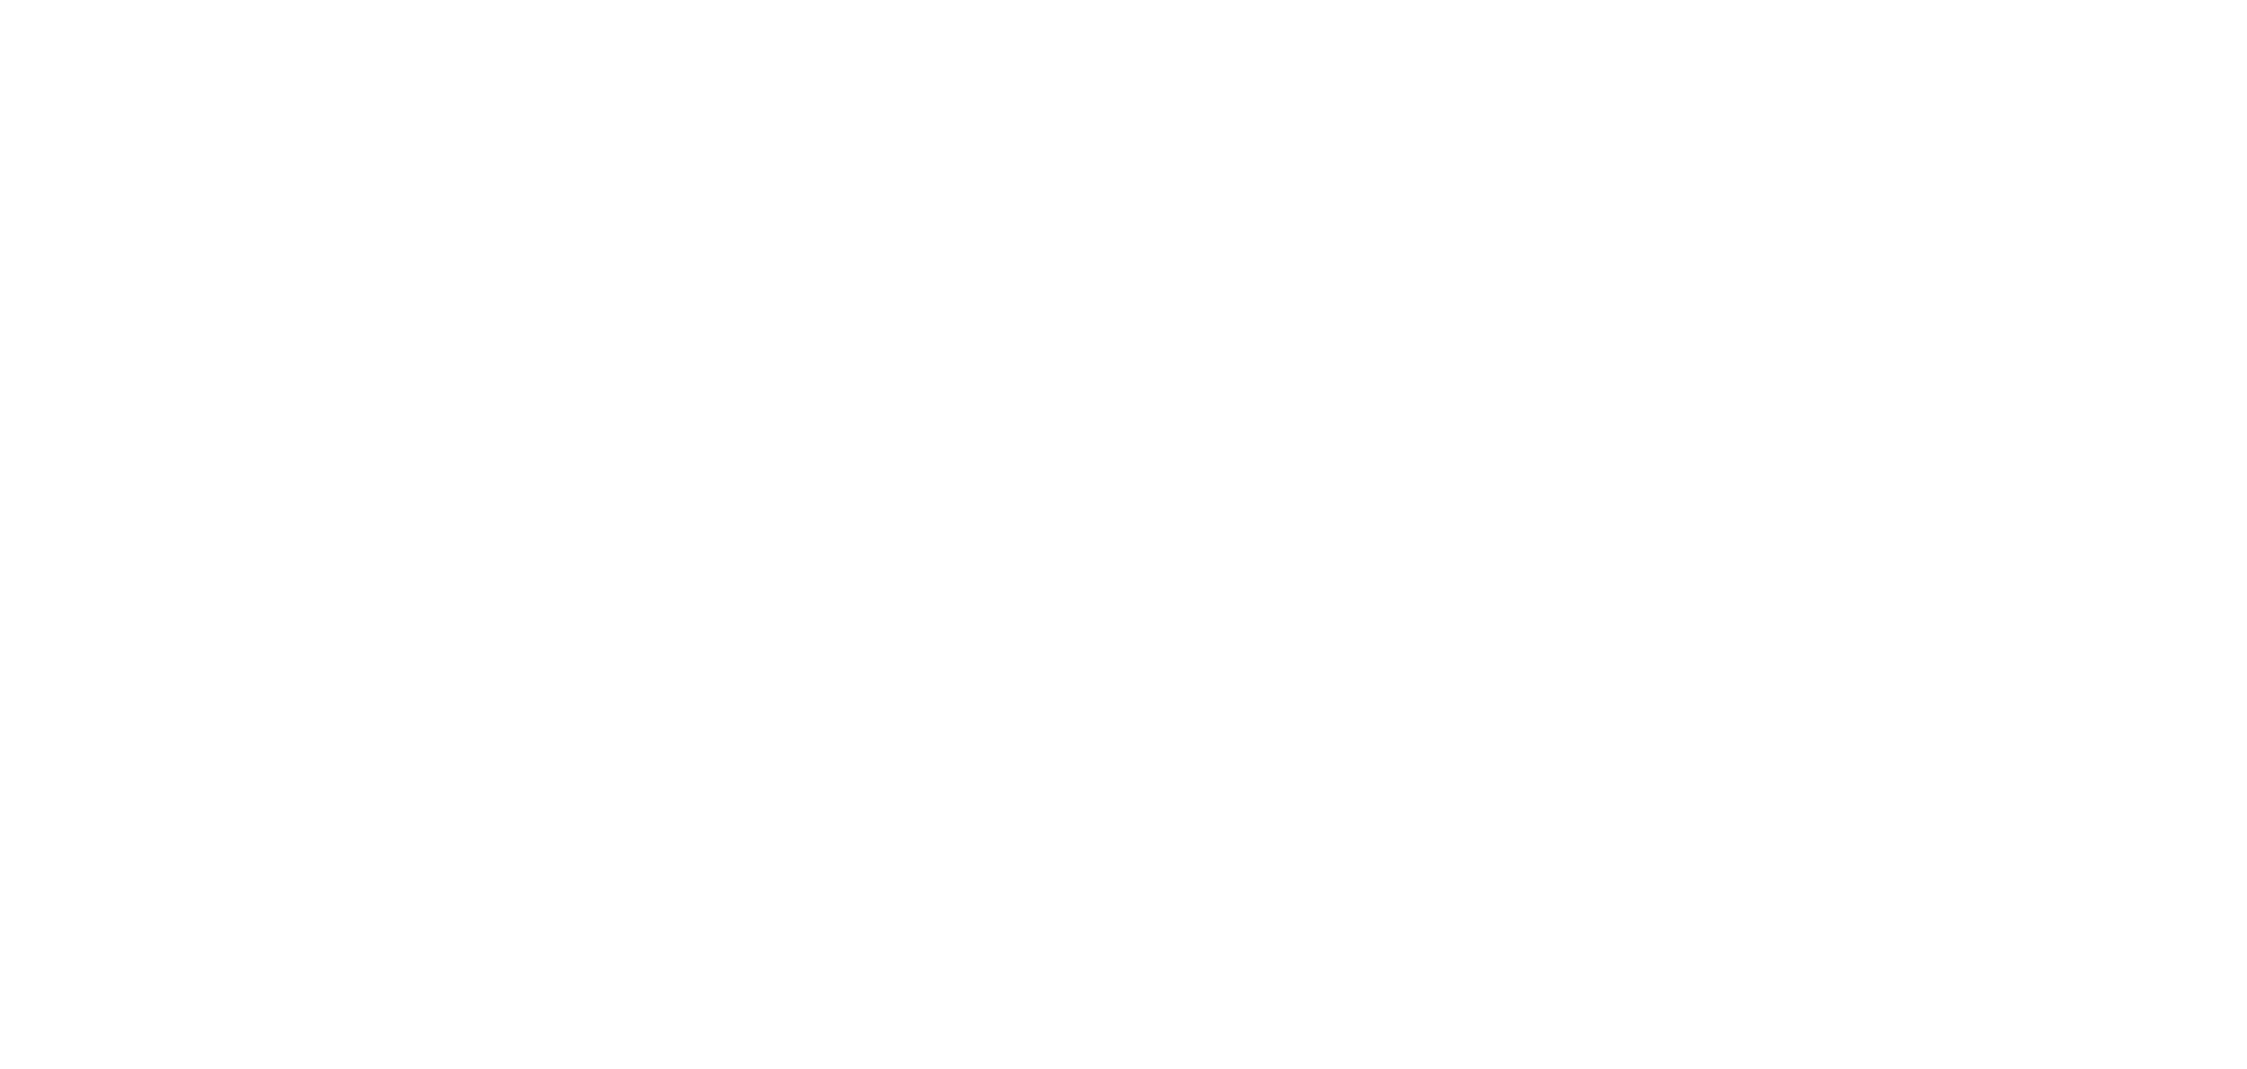

In [9]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

def update_K(frame):
    K_axes.cla()
    K_axes.patch.set_alpha(0)
    K_f.patch.set_alpha(0)
    for aop_group_num in range(1, 4):
        AOP_model = spectrum_utils.load_aop_model(aop_group_num=aop_group_num)
        wvs = AOP_model.index

        K_axes.plot(wvs[:frame], (AOP_model.loc[wvs[:frame]].Kd_m + AOP_model.loc[wvs[:frame]].Kd_c), ls=styles[aop_group_num], color=yellow_hex, label=f"Group {aop_group_num}", alpha=1)
    
    # Set up the axes
    K_axes.set_xlim(min(AOP_model.index), max(AOP_model.index))
    plotting.format_axis_for_ppt(K_axes)
    K_axes.set_xticklabels([])
    K_axes.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
    K_axes.set_xlabel("Wavelength (nm)", color="white")
    return K_axes

# Create the figures and axes
K_f, K_axes = plt.subplots(1, 1, figsize=(9, 4), dpi=300)

# Create the animation
ani_bb = FuncAnimation(K_f, update_K, frames=len(AOP_model.index), blit=False, repeat=False, interval=60, repeat_delay=1000)

writer = FFMpegWriter(fps=30, metadata={'loop': 0}, extra_args=['-loop', '1'])
ani_bb.save(file_ops.RESULTS_DIR_FP / "figures/K_models_animation.gif", writer=writer, savefig_kwargs={'transparent': True}, dpi=200)

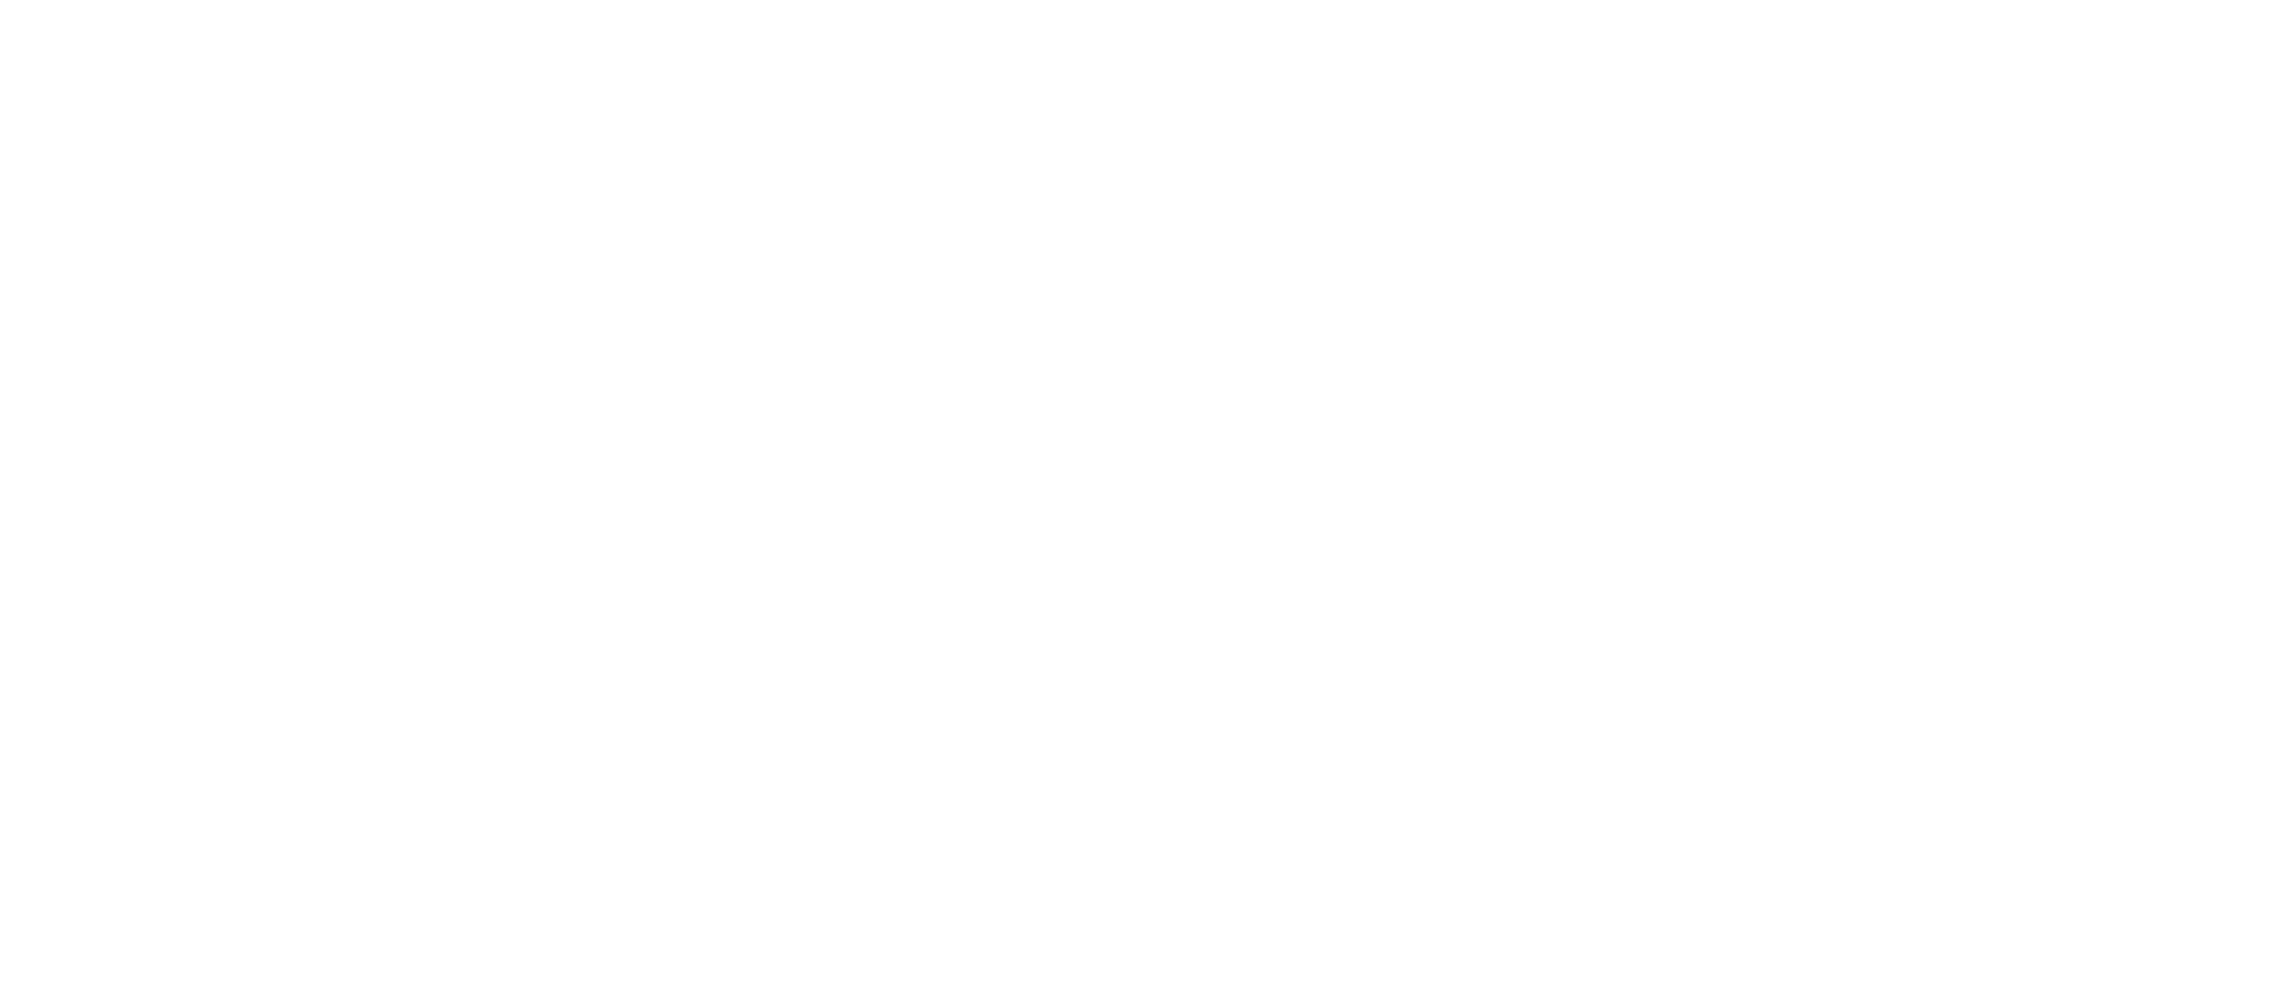

In [10]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

def update_bb(frame):
    bb_axes.cla()
    bb_axes.patch.set_alpha(0)
    bb_f.patch.set_alpha(0)
    for aop_group_num in range(1, 4):
        AOP_model = spectrum_utils.load_aop_model(aop_group_num=aop_group_num)
        wvs = AOP_model.index

        bb_axes.plot(wvs[:frame], (AOP_model.loc[wvs[:frame]].bb_m + AOP_model.loc[wvs[:frame]].bb_c), ls=styles[aop_group_num], color=red_hex, label=f"Group {aop_group_num}", alpha=1)
    
    # Set up the axes
    bb_axes.set_xlim(min(AOP_model.index), max(AOP_model.index))
    plotting.format_axis_for_ppt(bb_axes)
    bb_axes.set_xticklabels([])
    bb_axes.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')

    return bb_axes

# Create the figures and axes
bb_f, bb_axes = plt.subplots(1, 1, figsize=(9, 4), dpi=300)

# Create the animation
ani_bb = FuncAnimation(bb_f, update_bb, frames=len(AOP_model.index), blit=False, repeat=False, interval=60, repeat_delay=1000)


writer = FFMpegWriter(fps=30, metadata={'loop': 0}, extra_args=['-loop', '1'])
ani_bb.save(file_ops.RESULTS_DIR_FP / "figures/bb_models_animation.mp4", writer=writer, savefig_kwargs={'transparent': True}, dpi=200)

# Validation spectra

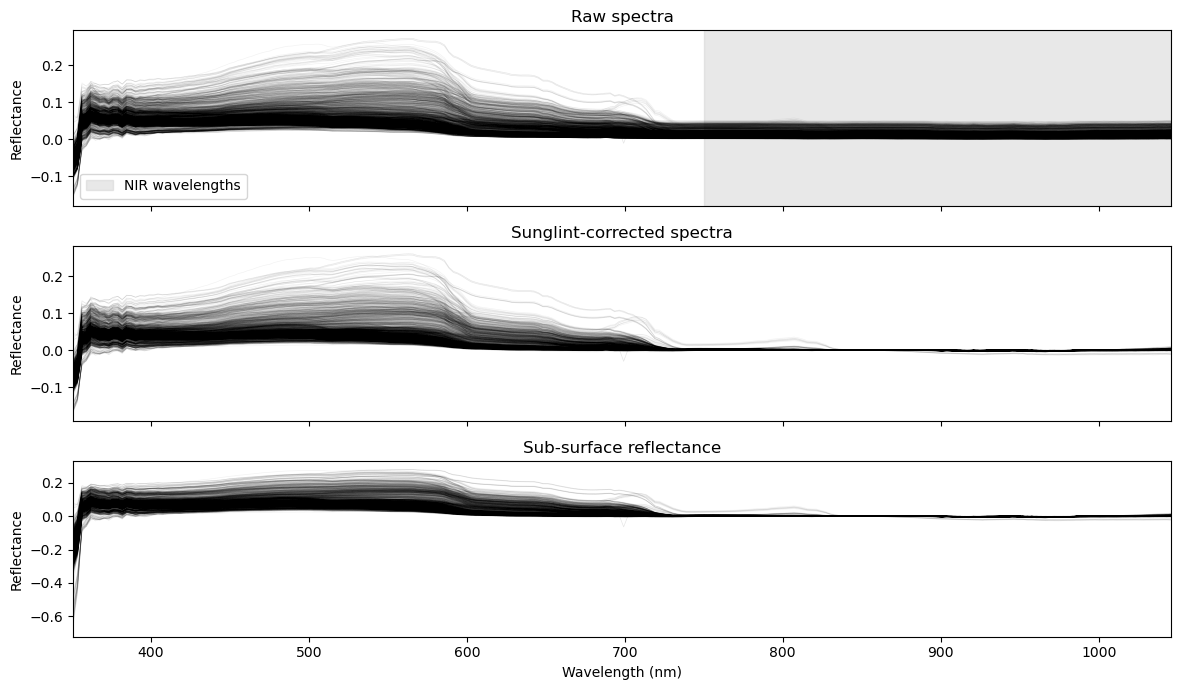

In [11]:
# benthic counts data
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
# spectral data (PRISM-measured reflectance from nearby pixels)
spectra_raw = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_spectra.csv")
spectra_raw.columns = spectra_raw.columns.astype(float)


fig, ax = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

NIR_wvs = (750, 1100)
SENSOR_LIMS = (450, 690)

ax[0].plot(spectra_raw.columns, spectra_raw.values.T, color=(0,0,0,0.05), lw=0.5);
# shade NIR waveband: (https://www.lidsen.com/journals/aeer/aeer-02-03-017)
ax[0].axvspan(min(NIR_wvs), max(spectra_raw.columns) if max(spectra_raw.columns) < max(NIR_wvs) else max(spectra_raw.columns), color='lightgrey', alpha=0.5, zorder=-2, label="NIR wavelengths")
ax[0].set_title("Raw spectra")
ax[0].legend()

# sun glint correction - subtract values between 750 and 1100 (NIR) from rest of data
spectra_deglinted = spectrum_utils.deglint_spectra(spectra_raw, NIR_wvs)

# calculate sub-surface reflectance (from Lee et al. 1998)
spectra_corrected = spectrum_utils.retrieve_subsurface_reflectance(spectra_deglinted)

ax[1].plot(spectra_deglinted.columns, spectra_deglinted.values.T, color=(0,0,0,0.05), lw=0.5);
ax[1].set_title("Sunglint-corrected spectra")

# plot corrected spectra
ax[2].plot(spectra_corrected.columns, spectra_corrected.values.T, color=(0,0,0,0.05), lw=0.5);
ax[2].set_title("Sub-surface reflectance")

for a in ax:
    a.set_xlim(spectra_corrected.columns.min(), spectra_corrected.columns.max())
    a.set_ylabel("Reflectance")
ax[2].set_xlabel("Wavelength (nm)")
    
plt.tight_layout()

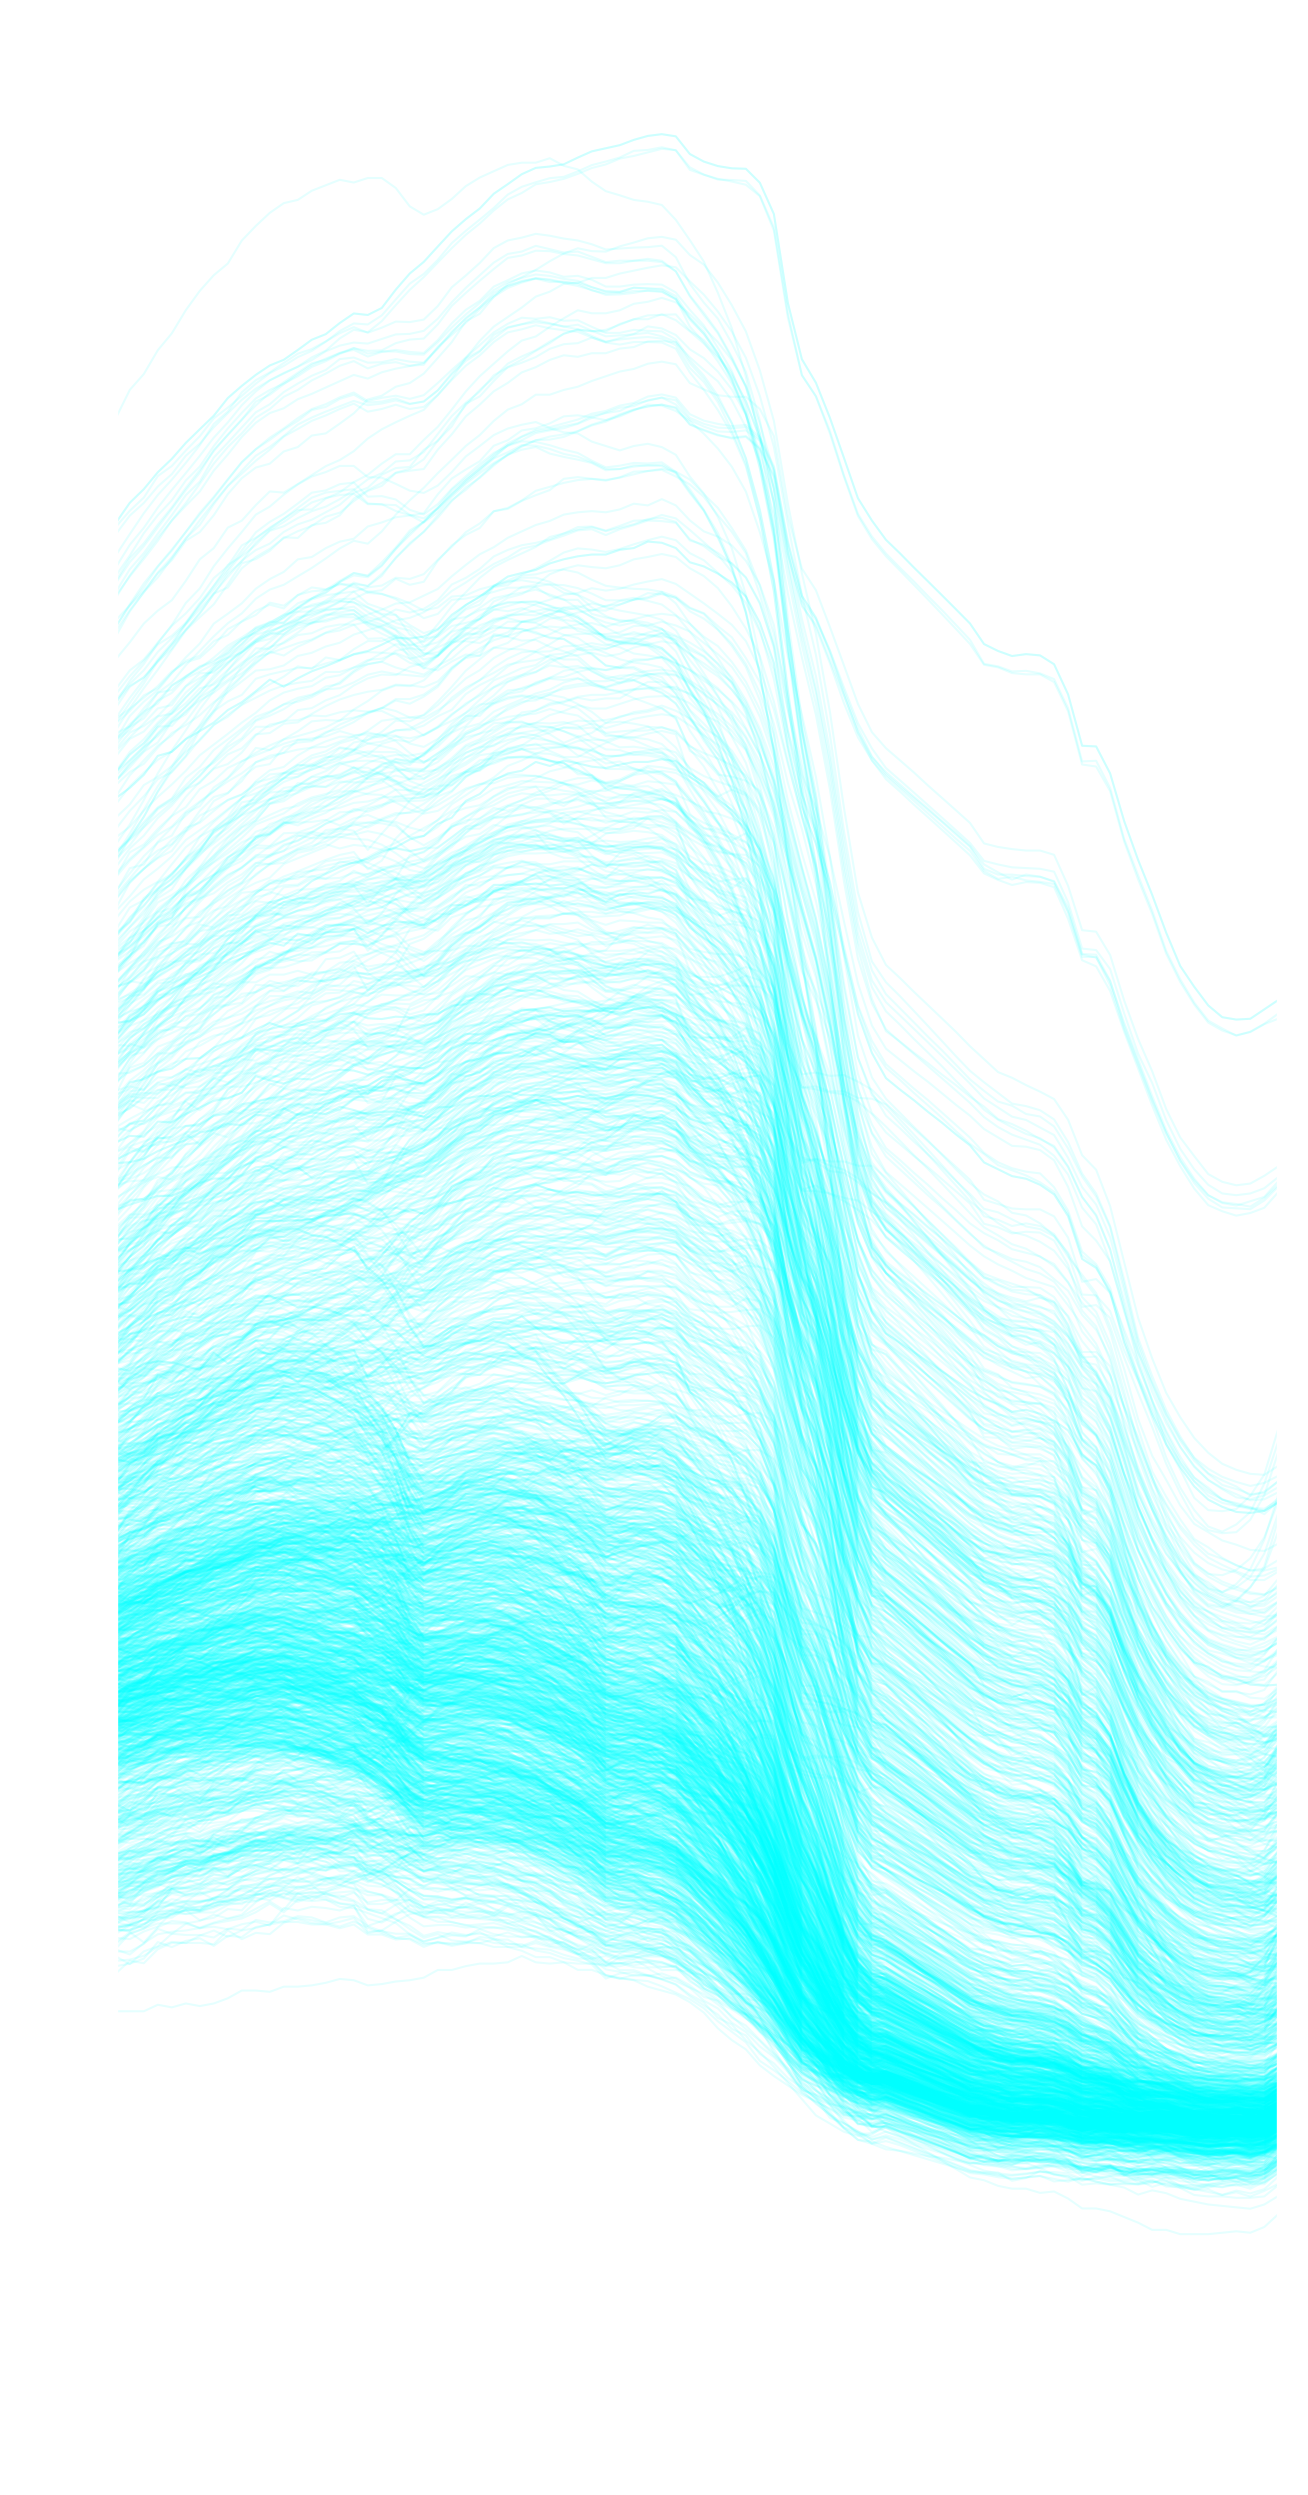

In [12]:
# clip spectra to AOP valid range (instrument calibration limitations)
ind = (spectra_corrected.columns > min(SENSOR_LIMS)) & (spectra_corrected.columns < max(SENSOR_LIMS))
prism_spectra = spectra_corrected.loc[:, ind]

validation_spectra_f, validation_spectra_ax = plt.subplots(1, 1, figsize=(5, 10), dpi=300)
validation_spectra_ax.plot(prism_spectra.columns, prism_spectra.values.T, color=(0,1,1,0.1), lw=0.5);
validation_spectra_ax.set_xlim(min(prism_spectra.columns), max(prism_spectra.columns));

validation_spectra_ax = plotting.format_axis_for_ppt(validation_spectra_ax) 
# [validation_spectra_ax.spines[pos].set_color('white') for pos in validation_spectra_ax.spines.keys()]
# # set ticks to be white
# validation_spectra_ax.tick_params(axis='x', colors='white')
# validation_spectra_ax.tick_params(axis='y', colors='white')
validation_spectra_ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
validation_spectra_ax.set_xlabel("Wavelength (nm)", color="white")
validation_spectra_ax.set_ylabel("Reflectance", color="white")
validation_spectra_ax.set_yticklabels([])
validation_spectra_f.savefig(file_ops.RESULTS_DIR_FP / "figures/validation_spectra.png", dpi=300, transparent=True)

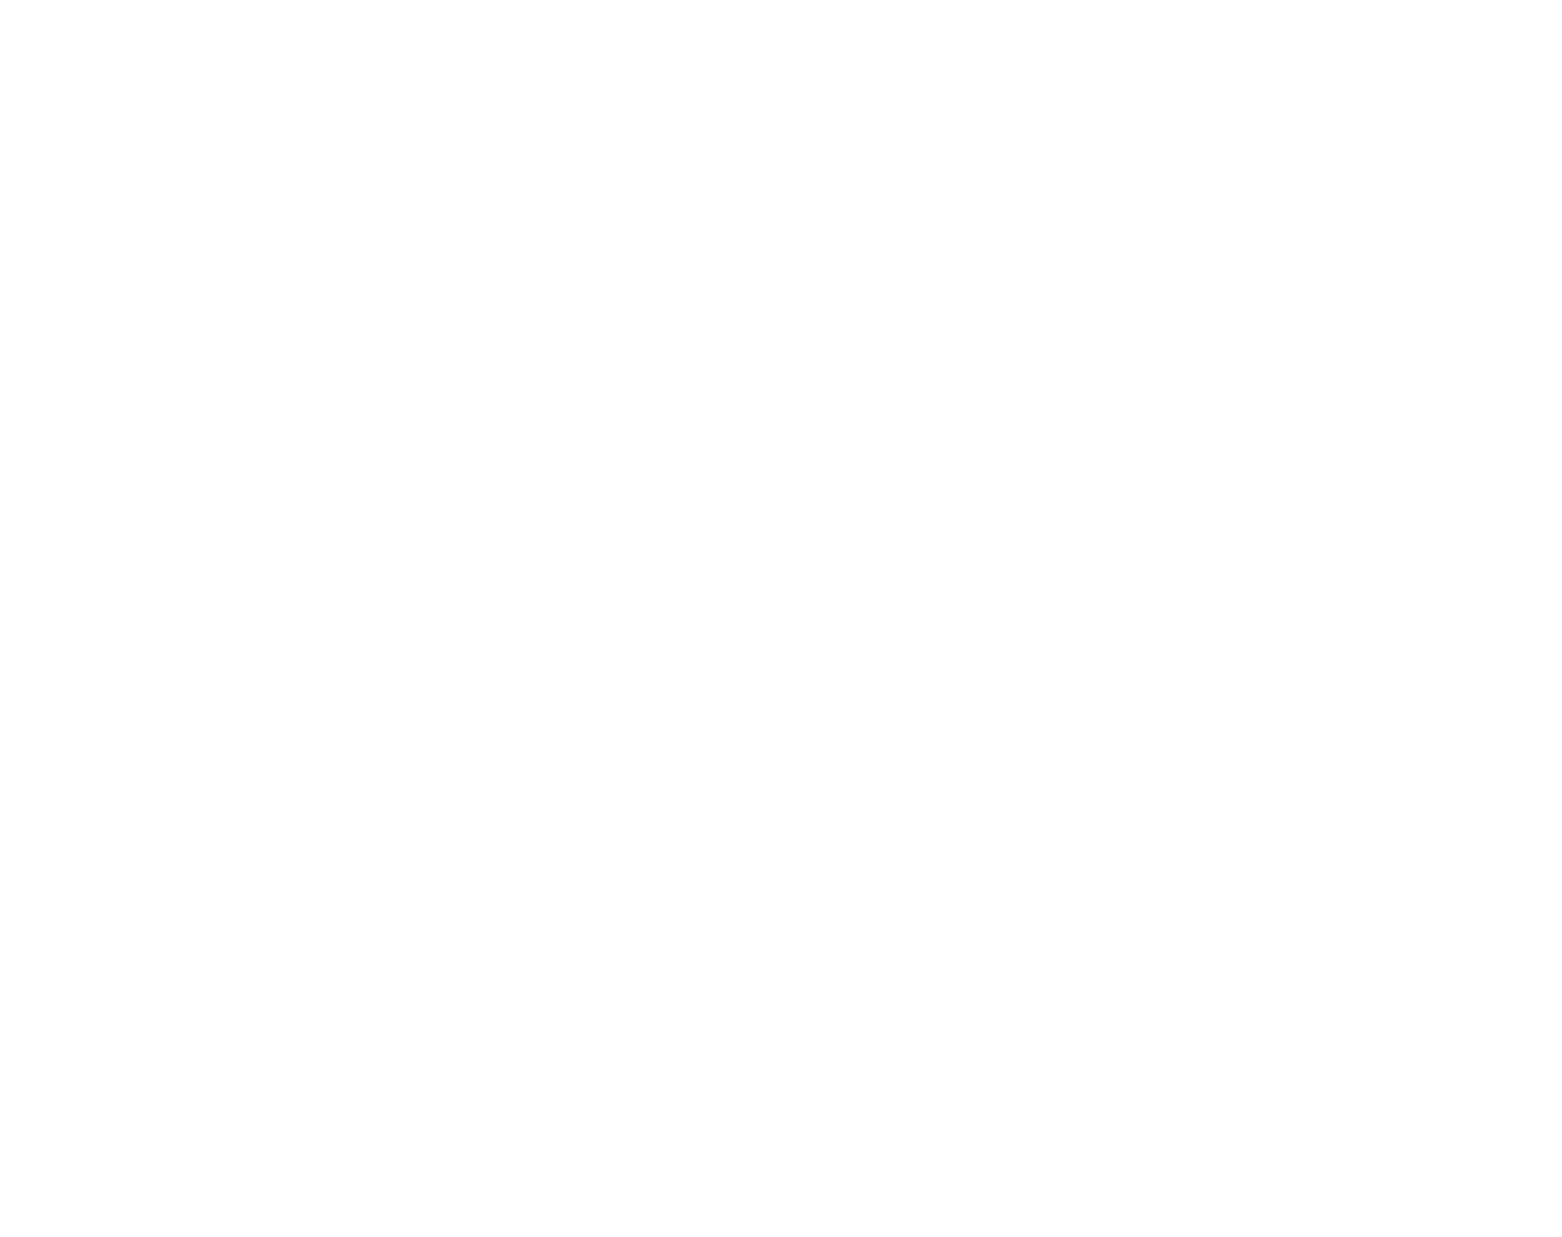

In [13]:
# create animation of spectra being added to figure, one by one
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 1, dpi=300)
ax.set_xlim(min(prism_spectra.columns), max(prism_spectra.columns))
lim_prism_spectra = prism_spectra.iloc[::10, :]
# order spectrum by size of first value
lim_prism_spectra = lim_prism_spectra.iloc[np.argsort(lim_prism_spectra.iloc[:, 0])]



# ax.set_ylim([0, 0.27])

def update(i):
    ax.cla()
    fig.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)
    ax.plot(lim_prism_spectra.columns, lim_prism_spectra[:i].values.T, color=(0, 1, 1, 0.5), lw=0.5)
    ax.set_xlim(min(lim_prism_spectra.columns), max(lim_prism_spectra.columns))
    # format axis
    plotting.format_axis_for_ppt(ax)
    ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.05, which='both')
    # set ytick labels empty
    ax.set_yticklabels([])
    ax.set_ylim(0, np.max(lim_prism_spectra.values.T)*1.1)
    return ax

ani = FuncAnimation(fig, update, frames=range(lim_prism_spectra.shape[0]), interval=1, repeat=False)
writer = FFMpegWriter(fps=30, metadata={'loop': 0}, extra_args=['-loop', '-1'])

# save animation with transparent background
ani.save(file_ops.RESULTS_DIR_FP / "figures/validation_spectra_animation_static.gif", writer=writer, savefig_kwargs={'transparent': True})

## Wavelength?

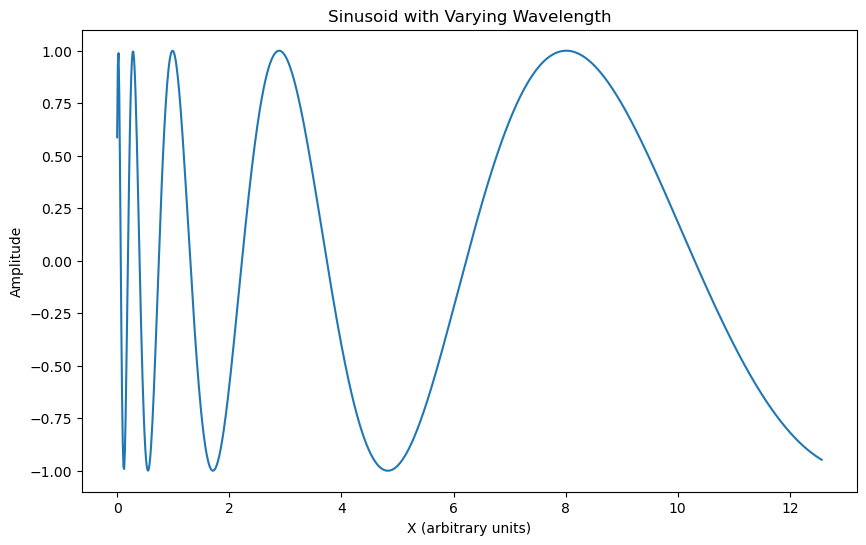

In [14]:
# plot sinusoid of varying wavelengths between min(wvs) and max(wvs)
import numpy as np
import matplotlib.pyplot as plt

# Define the range of wavelengths (in nm)
min_wavelength = 10
max_wavelength = 1000

# Define the x-axis range (in arbitrary units)
x = np.linspace(0, 4 * np.pi, 1000)

# Calculate the wavelength at each point on the x-axis
wavelengths = np.linspace(min_wavelength, max_wavelength, len(x))

# Calculate the frequency at each point on the x-axis (inverse of wavelength)
frequencies = 1 / wavelengths

# Generate the sinusoidal wave with varying frequency
y = np.sin(np.cumsum(frequencies) * 2 * np.pi)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the sinusoid
ax.plot(x, y)

# Add labels and title
ax.set_xlabel('X (arbitrary units)')
ax.set_ylabel('Amplitude')
ax.set_title('Sinusoid with Varying Wavelength')

# Show the plot
plt.show()

# Depth

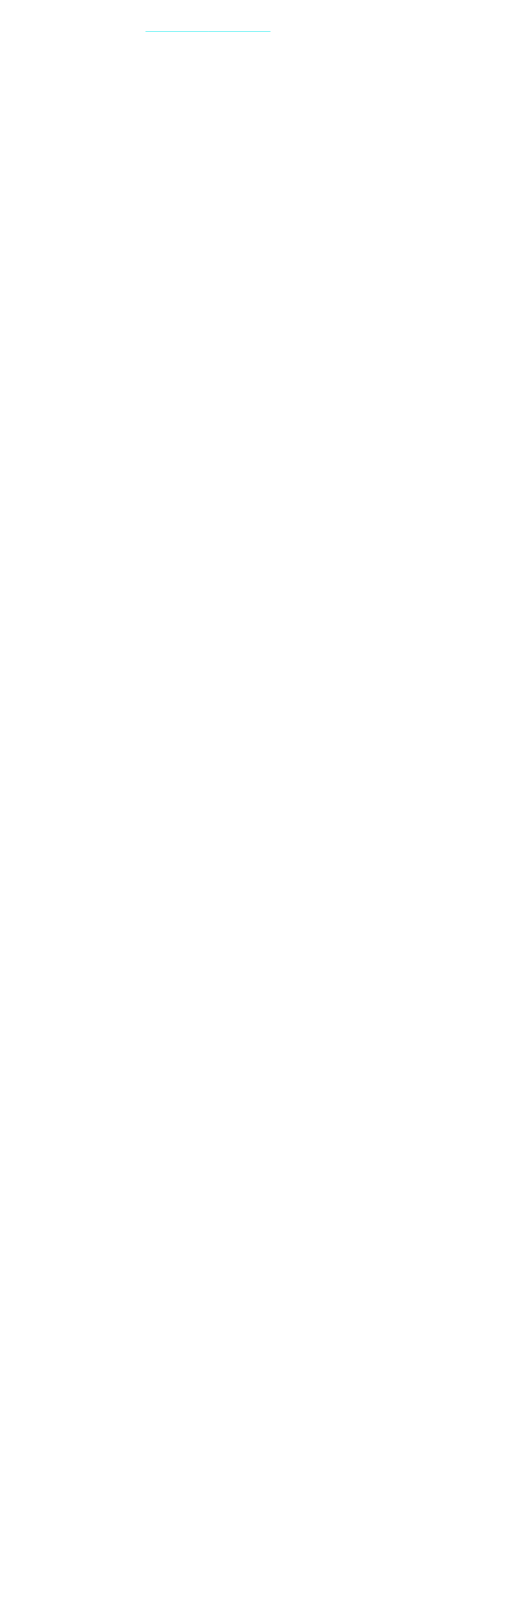

In [15]:
import matplotlib
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(3, 10), dpi=200)

# Initialize the bar with a value of 0
bar = ax.bar(0, 0, width=0.1, color='blue')

# format
ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-10.5, 0)
plotting.format_axis_for_ppt(ax)
ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.05, which='both')
ax.set_xticklabels([])
ax.set_ylabel("Depth (m)", color="white", labelpad=0)  # Adjust labelpad to prevent cutoff
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.patch.set_alpha(0.0)
fig.patch.set_alpha(0.0)
fig.subplots_adjust(right=0.75)  # Adjust the right margin to prevent cutoff

n_frames = 100
max_depth = 10

lin = np.linspace(0,1,n_frames)
heights = (max_depth * (1-lin**2))[::-1]

# Define the colormap
start_hex = "#72F4F6"
end_hex = "#0f2e5a"
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom", [start_hex, end_hex], N=n_frames)

# Define the update function for the animation
def update(frame):
    height = -frame  # Height decreases from 0 to -10
    # for h in heights:
    color = cmap(int(frame*(n_frames/max_depth)))
    bar[0].set_height(height)  # Update bar height
    bar[0].set_color(color)  # Update bar color
    return bar

ani = FuncAnimation(fig, update, frames=heights, repeat=False)

# save animation with transparent background
writer = FFMpegWriter(fps=30, extra_args=['-loop', '-1'])
# writer = PillowWriter(fps=40)
ani.save(file_ops.RESULTS_DIR_FP / "figures/height.mp4", writer=writer, savefig_kwargs={'transparent': True})